<a href="https://colab.research.google.com/github/shunnyK/AI/blob/main/week9_AlcoholSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0160 - val_loss: 0.0071
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - val_loss: 0.0092
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - val_loss: 0.0086
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 0.0046
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - val_loss: 0.0040
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.0096e-04 - val_loss: 0.0081
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.7651e-04 - val_loss: 0.0077
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.4915e-04 - val_loss: 0.0037
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.7326e-04 - val_loss: 0.0064
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.5

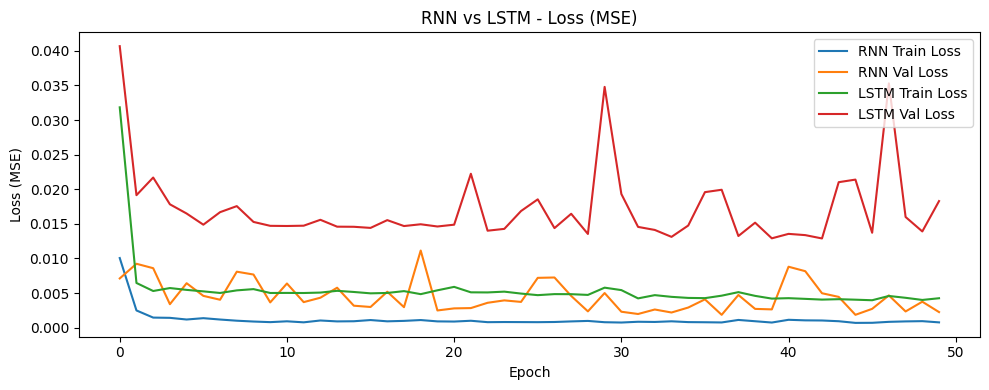

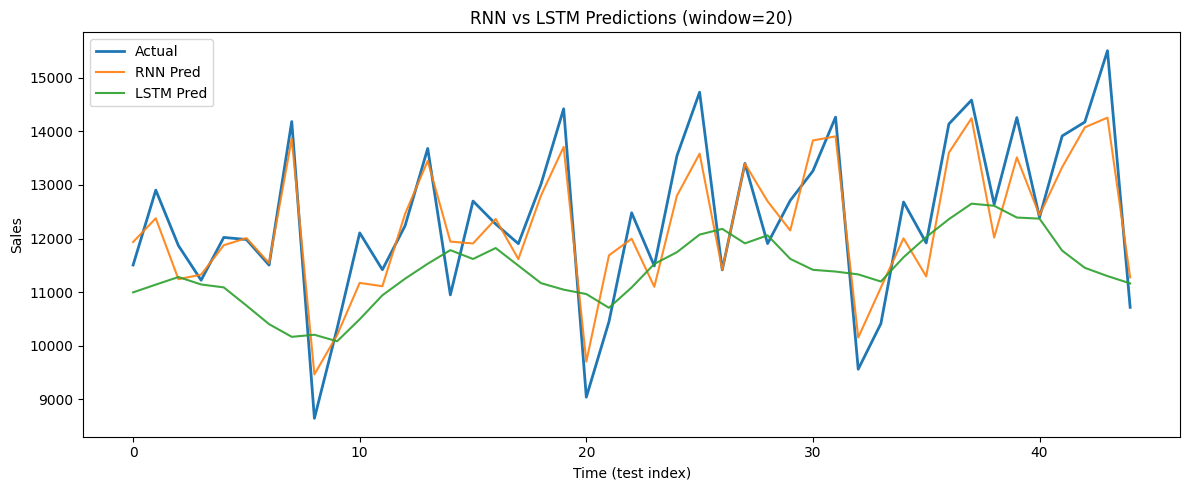

RNN Test MSE : 351329.4688
LSTM Test MSE: 2845642.2500


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense

FILE_PATH = "/content/drive/MyDrive/Alcohol_Sales.csv"
COL_NAME  = "S4248SM144NCEN"
WINDOW    = 20
EPOCHS    = 50
BATCH     = 8
TRAIN_RATIO = 0.8  # 80% 학습, 20% 테스트


# 1) 데이터 로드 & 스케일링
df = pd.read_csv(FILE_PATH)
series = df[COL_NAME].astype("float32").values.reshape(-1, 1)

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)


# 2) 학습/테스트 분할 (순차 분할)
split_idx  = int(len(series_scaled) * TRAIN_RATIO)
train_data = series_scaled[:split_idx]
test_data  = series_scaled[split_idx:]


# 3) 윈도우 만들기 (수작업)
#    X: (samples, WINDOW, 1), y: (samples, 1)

def make_xy(arr, window):
    X, y = [], []
    for i in range(len(arr) - window):
        X.append(arr[i:i+window])
        y.append(arr[i+window])
    X = np.array(X, dtype="float32")
    y = np.array(y, dtype="float32")
    return X, y

X_train, y_train = make_xy(train_data, WINDOW)
X_test,  y_test  = make_xy(test_data,  WINDOW)


# 4) 모델 생성 함수
def build_rnn(window):
    m = Sequential([
        SimpleRNN(64, input_shape=(window, 1)),
        Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

def build_lstm(window):
    m = Sequential([
        LSTM(64, input_shape=(window, 1)),
        Dense(1)
    ])
    m.compile(optimizer="adam", loss="mse")
    return m


# 5) 학습 (RNN / LSTM)
rnn_model = build_rnn(WINDOW)
lstm_model = build_lstm(WINDOW)

rnn_hist = rnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS, batch_size=BATCH,
    validation_data=(X_test, y_test),
    verbose=1
)

lstm_hist = lstm_model.fit(
    X_train, y_train,
    epochs=EPOCHS, batch_size=BATCH,
    validation_data=(X_test, y_test),
    verbose=1
)


# 6) 손실 곡선 비교
plt.figure(figsize=(10,4))
plt.plot(rnn_hist.history['loss'], label='RNN Train Loss')
plt.plot(rnn_hist.history['val_loss'], label='RNN Val Loss')
plt.plot(lstm_hist.history['loss'], label='LSTM Train Loss')
plt.plot(lstm_hist.history['val_loss'], label='LSTM Val Loss')
plt.title('RNN vs LSTM - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.tight_layout()
plt.show()

# 7) 예측 → 역스케일 → 시각화

rnn_pred_scaled  = rnn_model.predict(X_test,  verbose=0)
lstm_pred_scaled = lstm_model.predict(X_test, verbose=0)

# y_test, 예측 모두 (.,1) 모양 → 스케일 역변환 가능
y_test_inv   = scaler.inverse_transform(y_test)
rnn_pred_inv = scaler.inverse_transform(rnn_pred_scaled)
lstm_pred_inv= scaler.inverse_transform(lstm_pred_scaled)

plt.figure(figsize=(12,5))
plt.plot(y_test_inv,   label='Actual', linewidth=2)
plt.plot(rnn_pred_inv, label='RNN Pred', alpha=0.9)
plt.plot(lstm_pred_inv,label='LSTM Pred', alpha=0.9)
plt.title(f'RNN vs LSTM Predictions (window={WINDOW})')
plt.xlabel('Time (test index)')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()


# 8) 성능 비교 (MSE)
rnn_mse  = mean_squared_error(y_test_inv, rnn_pred_inv)
lstm_mse = mean_squared_error(y_test_inv, lstm_pred_inv)
print(f"RNN Test MSE : {rnn_mse:.4f}")
print(f"LSTM Test MSE: {lstm_mse:.4f}")